# **Experiment:** Exact local recovery

This notebook reproduces the results of the numerical experiments in

> C. Arrieta and C. A. Sing Long, "*Exact Local Recovery for Chemical Shift Imaging*."

You can use the following code to cite our work.
```bibtex
@article{arrieta_exact_2025, 
  title   = {Exact Local Recovery for Chemical Shift Imaging},  
  author  = {Arrieta, Cristóbal and Sing Long, Carlos A.}, 
  date    = {2025-03-31}
}
```

In [1]:
import numpy as np
import scipy.io as scpio

from os.path import exists

import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from matplotlib.transforms import Bbox

from tqdm import tqdm

import sys

if "../.." not in sys.path:
    sys.path.insert(0, "../..")

In [2]:
# load precomputed data
LOAD_DATA = True
# layout for plots
PLT_LAYOUT = 'constrained'
BBOX_INCHES = Bbox([ [0, 0], [6, 6] ])
# save figures
def savefig(fname):
  plt.savefig(f'FIG/E02_{fname:s}.png', bbox_inches=BBOX_INCHES, dpi=300)
  plt.savefig(f'FIG/E02_{fname:s}.eps', bbox_inches=BBOX_INCHES)

## Contents

1. [Loading the data](#loading-the-data)
2. [The residual](#the-residual)
3. [The radius of monotonicity](#the-radius-of-monotonicity)
4. [Bounding the radius of monotonicity](#bounding-the-radius-of-monotonicity)

## Loading the data

Load the data used to reproduce the experiments. 

In [3]:
# number of species
ns = 3
# undersampling
usamp = 1
# select 0.986
DTE = '0.986'
# filename
fname = f'PHANTOM_NUM_WFS_DTE_{DTE}_FM_110'
# source folder
folder = '../../data/phantoms/'
# load .mat file
data = scpio.loadmat(folder + fname + '.mat')
# signal
So = data['imDataParams'][0, 0]['images']
So = So[:, :, :, :, :].squeeze()
So = So[::usamp, ::usamp, :]
# echo times
te = np.unique(data['imDataParams'][0, 0]['TE'].ravel())
# field
field = float(data['imDataParams'][0, 0]['FieldStrength'][0][0])
# true concentrations
co = data['xGT'][::usamp, ::usamp, :ns]
# true parameters
xio = data['xGT'][::usamp, ::usamp, ns].ravel()

In [4]:
# number of echo times
ne = te.size
# image shape
imshape = So.shape[:-1]
# number of pixels
npx = np.prod(So.shape[:-1])
# true signal
so = So.reshape((npx, ne))
# signal norm
so_nrm = np.linalg.norm(so, axis=1)

print(f'Echo times and echo spacing')
for I in range(ne):
  if I > 0:
    print(f'   Echo time {I:2d} : {te[I]:.6f} s  (Interval : {te[I] - te[I-1]:.6f} s)')
  else:
    print(f'   Echo time {I:2d} : {te[I]:.6f} s')

Echo times and echo spacing
   Echo time  0 : 0.001238 s
   Echo time  1 : 0.002224 s  (Interval : 0.000986 s)
   Echo time  2 : 0.003210 s  (Interval : 0.000986 s)
   Echo time  3 : 0.004196 s  (Interval : 0.000986 s)
   Echo time  4 : 0.005182 s  (Interval : 0.000986 s)
   Echo time  5 : 0.006168 s  (Interval : 0.000986 s)


Assemble the model matrix for water and a multipeak fat model. 

In [6]:
from CSITools.routines.models import get_wfsilicone_model
from CSITools.routines.models import assemble_model_matrix

In [7]:

# signal parameters
cshifts, cweights = get_wfsilicone_model(field, mp=True)
# model matrix
M = assemble_model_matrix(te, cshifts, cweights)
# orthogonal projector onto range(M)^{\perp}
PR = np.eye(ne) - M @ np.linalg.pinv(M)

print(f'Model matrix')
print(f'   Size                : {M.shape[0]} x {M.shape[1]}')
print(f'   Singular values')
print(f'    - Maximum          : {np.linalg.svdvals(M)[0]:.3f}')
print(f'    - Minimum          : {np.linalg.svdvals(M)[-1]:.3f}')

Model matrix
   Size                : 6 x 3
   Singular values
    - Maximum          : 2.644
    - Minimum          : 1.619


## The residual

Define the *weight matrix* as
$$
  \boldsymbol{W}(\xi) = \operatorname{diag}(e^{2\pi i \xi t_1}, \ldots, e^{2\pi i \xi t_{n_e}}).
$$
Then the *residual matrix* is
$$
  \boldsymbol{R}(\xi) = \boldsymbol{W}(\xi) \boldsymbol{P}_R \boldsymbol{W}(-\xi)
$$
where
$$
  \boldsymbol{P}_R = \boldsymbol{I}_{n_e} - \boldsymbol{\Phi}\boldsymbol{\Phi}^+
$$
is the orthogonal projector onto $\operatorname{range}(\boldsymbol{\Phi})^{\perp}$. The $n$-th derivative of the residual matrix can be computed recursively as
$$
  \boldsymbol{R}^{(n)}(\xi) = 2\pi i [\boldsymbol{T},\, \boldsymbol{R}^{(n - 1)}(\xi)]\qquad n\in \mathbb{N},
$$
where $[\cdot,\, \cdot]$ denotes the commutator between two matrices and
$$
  \boldsymbol{T} = \operatorname{diag}(t_1,\ldots, t_{n_e}).
$$

In [8]:
# weight matrix
def W(xi):
  return np.diag(np.exp(2 * np.pi * 1j * te * xi))

# residual matrix
def R(xi, n=0):
  Rx = W(xi) @ (PR @ W(-xi))
  for I in range(n):
    Rx = (2 * np.pi * 1j) * (np.diag(te) @ Rx - Rx @ np.diag(te))
  return Rx

The *residual* is the function
$$
  f(\xi) = \frac{1}{2}\| \boldsymbol{R}(\xi) \boldsymbol{s}_0\|_2^2\qquad\text{where}\qquad \boldsymbol{s}_0 = \boldsymbol{W}(\xi_0) \boldsymbol{F} \boldsymbol{c}_0
$$
for the true parameter $\xi_0$ and concentrations $\boldsymbol{c}_0$. We can write this explicitly as a function of $(\xi, \xi^*)$ as
$$
  f(\xi, \xi^*) = \frac{1}{2}\langle  \boldsymbol{s}_0,\, \boldsymbol{R}(\xi^*)\boldsymbol{R}(\xi) \boldsymbol{s}_0\rangle.
$$
Hence, the residual is *not* complex-differentiable, but it has Wirtinger derivatives of all orders. We can evaluate the residual $f$, the norm of its gradient $\nabla_W f$ given by
$$
  \nabla_W f(\xi, \xi^*) = \begin{bmatrix} \partial_{\xi} f(\xi,\xi^*) \\ \partial_{\xi^*} f(\xi,\xi^*) \end{bmatrix}
$$
and the smallest eigenvalue of its Hessian $\nabla^2_W f$ 
$$
  \nabla_W^2 f(\xi, \xi^*) = \begin{bmatrix} \partial_{\xi\xi} f(\xi,\xi^*) &  \partial_{\xi^*\xi} f(\xi,\xi^*) \\ \partial_{\xi\xi^*} f(\xi,\xi^*) & \partial_{\xi^*\xi^*} f(\xi,\xi^*) \end{bmatrix}
$$
at the true parameters at every pixel.

In [9]:
# residual
res_xio = np.zeros((npx,), dtype=float)
# norm of gradient
grad_xio = np.zeros((npx,), dtype=float)
# minimum singular value
evmin_hess_xio = np.zeros((npx,), dtype=float)

# compute
for I, (_s, _xi) in enumerate(zip(so, xio)):
  res_xio[I] = 0.5 * np.linalg.norm(R(_xi) @ _s) ** 2
  grad_xio[I] = np.abs(np.sum(np.conj(R(_xi) @ _s) * (R(_xi, 1) @ _s))) 
  evmin_hess_xio[I] = np.linalg.norm(R(_xi, 1) @ _s) ** 2 - np.abs(np.sum(np.conj(R(_xi, 0) @ _s) * (R(_xi, 2) @ _s)))

# reshape
res_xio = res_xio.reshape(imshape)
grad_xio = grad_xio.reshape(imshape)
evmin_hess_xio = evmin_hess_xio.reshape(imshape)

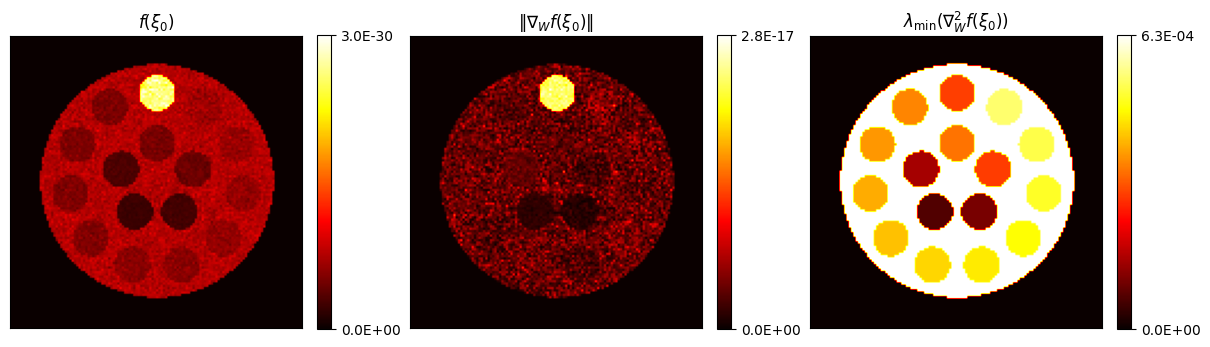

In [10]:
plt.figure(figsize=(12, 4), layout='constrained')
plt.subplot(1, 3, 1)
plt.imshow(res_xio, origin='lower', vmin=0.0, vmax=res_xio.max(), cmap='hot')
plt.xlim([ 0, imshape[0] - 1 ])
plt.ylim([ 0, imshape[1] - 1 ])
plt.xticks([])
plt.yticks([])
plt.axis('scaled')
plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1E}', ticks=[ 0.0, res_xio.max() ])
plt.title('$f(\\xi_0)$')
plt.subplot(1, 3, 2)
plt.imshow(grad_xio, origin='lower', vmin=0.0, vmax=grad_xio.max(), cmap='hot')
plt.xlim([ 0, imshape[0] - 1 ])
plt.ylim([ 0, imshape[1] - 1 ])
plt.xticks([])
plt.yticks([])
plt.axis('scaled')
plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1E}', ticks=[ 0.0, grad_xio.max() ])
plt.title('$\|\\nabla_{W} f(\\xi_0)\|$')
plt.subplot(1, 3, 3)
plt.imshow(evmin_hess_xio, origin='lower', vmin=0.0, vmax=evmin_hess_xio.max(), cmap='hot')
plt.xlim([ 0, imshape[0] - 1 ])
plt.ylim([ 0, imshape[1] - 1 ])
plt.xticks([])
plt.yticks([])
plt.axis('scaled')
plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1E}', ticks=[ 0.0, evmin_hess_xio.max() ])
plt.title('$\\lambda_{\\min}(\\nabla^2_{W} f(\\xi_0))$')
plt.show()

## The radius of monotonicity

Although the residual is not convex, the true parameters are strong minimizers, i.e., the Hessian is positive definite at the values of the true parameters. 

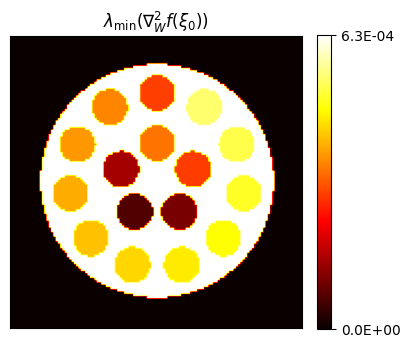

In [11]:
plt.figure(figsize=(4, 4), layout='constrained')
plt.imshow(evmin_hess_xio, origin='lower', vmin=0.0, vmax=evmin_hess_xio.max(), cmap='hot', aspect='auto')
plt.xlim([ 0, imshape[0] - 1 ])
plt.ylim([ 0, imshape[1] - 1 ])
plt.xticks([])
plt.yticks([])
plt.axis('scaled')
plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1E}', ticks=[ 0.0, evmin_hess_xio.max() ])
plt.title('$\\lambda_{\\min}(\\nabla^2_{W} f(\\xi_0))$')
plt.show()

We can determine the radius around the true parameters where the Hessian remains positive definite. We call this a *radius of monotonicity*. If $r_0$ is a radius of monotonicity for $\xi_0$ then it holds that
$$
  \xi\in \mathbb{H}^+:\quad |\xi - \xi_0| \leq r_0 \,\,\Rightarrow\,\,\nabla^2_W f(\xi) \cdot (\xi - \xi_0, \xi^* - \xi_0^*) \geq \mu |\xi - \xi_0|^2.
$$
The relevance of this is that if $\xi^{(0)}\in \mathbb{H}^+$ is within a radius of monotonicity of $\xi_0$ then gradient descent with a sufficiently small fixed step starting at $\xi^{(0)}$ converges to $\xi_0$.

We first observe that the smallest eigenvalue of the Hessian decays as we evaluate it further away from $\xi_0$.

In [12]:
from scipy.optimize import minimize_scalar

In [13]:
def evmin_hess_r(xi, s, r):
  # by convention radius is zero if signal is zero
  if np.linalg.norm(s) == 0.0:
    return 0.0
  # range
  if r <= xi.imag:
    alpha = np.pi / 2
  else:
    alpha = np.arcsin(xi.imag / r)
  tbounds = [ -alpha, np.pi + alpha]
  def fcn(t):
    z = xi + r * np.exp(1j * t)
    return np.linalg.norm(R(z, 1) @ s) ** 2 - np.abs(np.sum(np.conj(R(z, 0) @ s) * (R(z, 2) @ s)))
  # minimize over the boundary 
  evmin_r = minimize_scalar(fcn, bounds=tbounds, method='Bounded')['fun']
  return evmin_r

In [14]:
# radius to evaluate
r = np.linspace(0, 60, 50)
# vectorize
evmin_hess_xio = evmin_hess_xio.ravel()
# filename
fname = f'DAT/E02_EVMIN_HESS_RADIUS_DTE_{DTE}_USAMP{usamp}.npz'

if LOAD_DATA and exists(fname):
  evmin_hess_radius = np.load(fname)['evmin_hess_radius']
else:
  # radius
  evmin_hess_radius = np.zeros((npx, r.size), dtype=float)
  # progress bar
  pbar = tqdm(total=npx)
  for I, (_s, _so_nrm, _xi, _svmin) in enumerate(zip(so, so_nrm, xio, evmin_hess_xio)):
    if _so_nrm > 0.0:
      evmin_hess_radius[I] = np.array([ evmin_hess_r(_xi, _s, _r) for _r in r ], dtype=float) / _svmin
    pbar.update(1)
  pbar.close()
  # save
  np.savez_compressed(fname, evmin_hess_radius=evmin_hess_radius)

100%|██████████| 16384/16384 [06:05<00:00, 44.83it/s]  


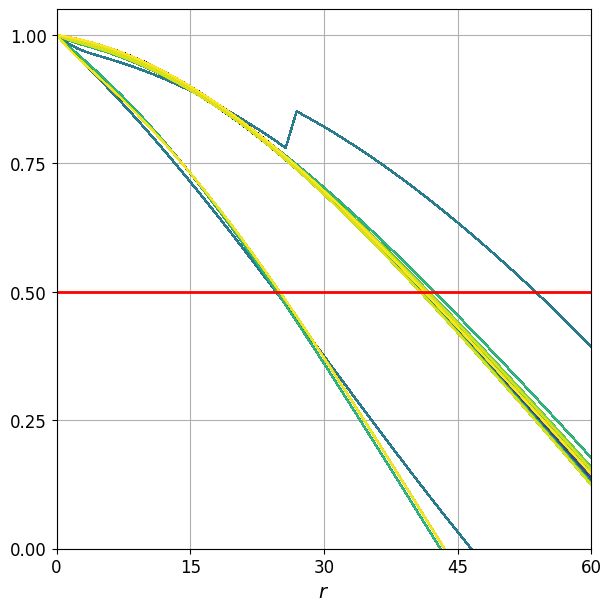

In [15]:
# number of pixels with non-zero signals
_npx = np.sum(so_nrm > 0.0)

plt.figure(figsize=(6, 6), layout=PLT_LAYOUT)
# color index
cidx = 0
for I, _so_nrm in enumerate(so_nrm):
  if _so_nrm > 0.0:
    cidx += 1
    plt.plot(r, evmin_hess_radius[I], linewidth=1, color=cm['viridis'](cidx/_npx))
plt.plot([ r.min(), r.max() ], [ 0.5, 0.5, ], color='r', linewidth=2)
plt.xlim([ r.min(), r.max() ])
plt.ylim([ 0.0, 1.05 ])
plt.xlabel('$r$', fontsize=14)
# plt.ylabel('$\\lambda_{\\min}(\\nabla_W^2 f(\\xi)) / \\lambda_{\\min}(\\nabla_W^2 f(\\xi_0))$', fontsize=14)
plt.xticks([ 0, 15, 30, 45, 60 ], fontsize=12)
plt.yticks([ 0.00, 0.25, 0.50, 0.75, 1.00 ], fontsize=12)
plt.grid('both')

savefig('MNT_RADIUS_VOXELS')

plt.show()

We see that the radius can be reasonably large. In this particular case we can determine the radius for which the smallest eigenvalue of the Hessian reduces its value by 50\%.

In [16]:
# ratio
sv_ratio = 0.5
# objective
def evmin_hess(xi, s):
  # reference value 
  svo = np.linalg.norm(R(xi, 1) @ s) ** 2 - np.abs(np.sum(np.conj(R(xi, 0) @ s) * (R(xi, 2) @ s)))
  # objective to minimize
  def _fcn(r):
    # range
    if r <= xi.imag:
      alpha = np.pi/2
    else:
      alpha = np.arcsin(xi.imag / r)
    tbounds = [ -alpha, np.pi + alpha]
    def __fcn(t):
      z = xi + r * np.exp(1j * t)
      return np.linalg.norm(R(z, 1) @ s) ** 2 - np.abs(np.sum(np.conj(R(z, 0) @ s) * (R(z, 2) @ s)))
    # minimize over the boundary 
    evmin_r = minimize_scalar(__fcn, bounds=tbounds, method='Bounded')['fun']
    return np.abs(evmin_r - sv_ratio * svo)
  # handle
  return _fcn

In [17]:
# filename
fname = f'DAT/E02_MNT_RADIUS_DTE_{DTE}_USAMP{usamp}.npz'

if LOAD_DATA and exists(fname):
  mnt_radius = np.load(fname)['mnt_radius']
else:
  # monotonicity radius
  mnt_radius = np.zeros((npx,), dtype=float)
  # progress bar
  pbar = tqdm(total = npx)
  for I, (_s, _so_nrm, _xi) in enumerate(zip(so, so_nrm, xio)):
    # compute radius
    if _so_nrm > 0.0:
      mnt_radius[I] = minimize_scalar(evmin_hess(_xi, _s), bounds=[ 0.0, 60.0 ], method='Bounded')['x']
    pbar.update(1)
  pbar.close()
  # reshape
  mnt_radius = mnt_radius.reshape(imshape)
  # save
  np.savez_compressed(fname, mnt_radius=mnt_radius)

100%|██████████| 16384/16384 [03:24<00:00, 80.08it/s]  


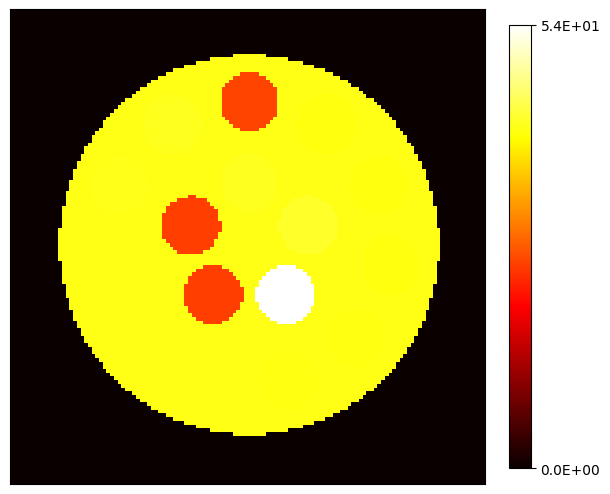

In [18]:
plt.figure(figsize=(6, 6), layout=PLT_LAYOUT)
plt.imshow(mnt_radius, origin='lower', vmin=0.0, vmax=mnt_radius.max(), cmap='hot', aspect='auto')
plt.xlim([ 0, imshape[0] - 1 ])
plt.ylim([ 0, imshape[1] - 1 ])
plt.xticks([])
plt.yticks([])
plt.axis('scaled')
plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1E}', ticks=[ 0.0, mnt_radius.max() ])

savefig('MNT_RADIUS_IMAGE')

plt.show()

## Bounding the radius of monotonicity

Although we can compute the radius of monotonicity numerically, it is useful to determine some figure of merit that allows us to bound it from below. Let $\tau_S = 4\pi (t_{n_e} - t_1)$ and $\tau_{n_e} = 4\pi t_{n_e}$. Then a lower bound for the radius can be determined numerically from the inequality
$$
  \operatorname{imag}(\xi_0 + \eta) \geq 0:\quad |\eta|\frac{e^{\tau_S \operatorname{imag}(\eta)} - 1}{\tau_S \operatorname{imag}(\eta)}\leq e^{-\tau_S\operatorname{imag}(\xi_0)} \frac{1}{4\sqrt{2}}\frac{\|\boldsymbol{R}''(\xi_0)\boldsymbol{s}_0\|_2}{\tau_{n_e}^{5/2}}\left(-1 + \sqrt{1 + 8\tau_{n_e}^2 \frac{\|\boldsymbol{R}'(\xi_0)\boldsymbol{s}_0\|_2^2}{\|\boldsymbol{R}''(\xi_0)\boldsymbol{s}_0\|_2^2}}\right)
$$ 

In [19]:
ts_factor = 4 * np.pi * (te[-1] - te[0])
te_factor = 4 * np.pi * te[-1]

def gamma(eta):
  if np.abs(eta.imag) < 1E-6:
    return np.abs(eta)
  return np.abs(eta) * (np.exp(ts_factor * eta.imag) - 1.0) / (ts_factor * eta.imag)

def gamma_bound(xi, s):
  qR = 8 * te_factor * (np.linalg.norm(R(xi, 1) @ s) / np.linalg.norm(R(xi, 2) @ s)) ** 2
  qB = np.linalg.norm(R(xi, 2) @ s) / np.sqrt(32 * te_factor ** 5)
  return qB * (-1.0 + np.sqrt(1.0 + qR)) * np.exp(-ts_factor * xi.imag) / np.linalg.norm(s) ** 2

In [20]:
# objective
def gamma_fcn(xi, s):
  # objective to minimize
  def _fcn(r):
    # range
    if r <= xi.imag:
      alpha = np.pi/2
    else:
      alpha = np.arcsin(xi.imag / r)
    tbounds = [ -alpha, np.pi + alpha]
    def __fcn(t):
      z = r * np.exp(1j * t)
      return -gamma(z)
    # minimize over the boundary 
    gmax_r = -minimize_scalar(__fcn, bounds=tbounds, method='Bounded')['fun']
    return np.abs(gmax_r - gamma_bound(xi, s))
  # handle
  return _fcn

In [21]:
# filename
fname = f'DAT/E02_BND_MNT_RADIUS_DTE_{DTE}_USAMP{usamp}.npz'

if LOAD_DATA and exists(fname):
  gamma_radius = np.load(fname)['gamma_radius']
else:
  # monotonicity radius
  gamma_radius = np.zeros((npx,), dtype=float)
  # progress bar
  pbar = tqdm(total = npx)

  for I, (_s, _so_nrm, _xi) in enumerate(zip(so, so_nrm, xio)):
    # compute radius
    if _so_nrm > 0.0:
      gamma_radius[I] = minimize_scalar(gamma_fcn(_xi, _s), bounds=[ 0.0, 50.0 ], method='Bounded')['x']
    pbar.update(1)
  pbar.close()
  # reshape
  gamma_radius = gamma_radius.reshape(imshape)
  # save
  np.savez_compressed(fname, gamma_radius=gamma_radius)

100%|██████████| 16384/16384 [00:23<00:00, 706.57it/s] 


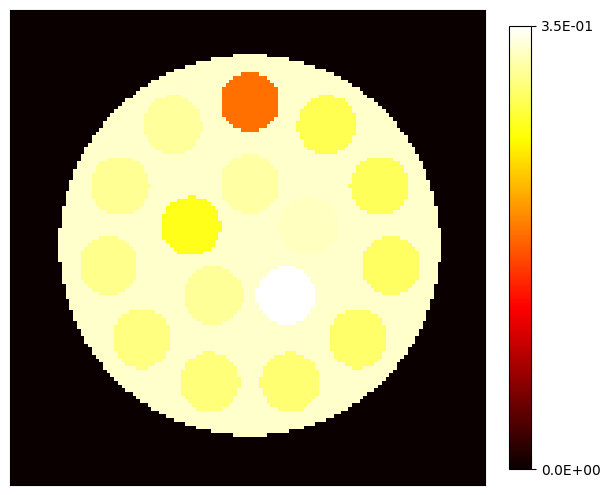

In [22]:
plt.figure(figsize=(6, 6), layout=PLT_LAYOUT)
plt.imshow(gamma_radius, origin='lower', vmin=0.0, vmax=gamma_radius.max(), cmap='hot', aspect='auto')
plt.xlim([ 0, imshape[0] - 1 ])
plt.ylim([ 0, imshape[1] - 1 ])
plt.xticks([])
plt.yticks([])
plt.axis('scaled')
plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1E}', ticks=[ 0.0, gamma_radius.max() ])

savefig('MNT_RADIUS_BND')

plt.show()

In practice, this bound is too loose and severely underestimates the radius of monotonicity. However, it shows that a suitable figure of merit is the quotient
$$
  \frac{\|\boldsymbol{R}'(\xi_0)\boldsymbol{s}_0\|_2^2}{\|\boldsymbol{R}''(\xi_0)\boldsymbol{s}_0\|_2^2}.
$$
As explained in the manuscript, we can obtain a slightly tighter bound by constructing a more complex estimate. 

In [23]:
from scipy.optimize import root_scalar

In [24]:
def r_estimate(xi, s):
  # factors
  a = [ 0, 0, 0, 0 ]
  a[0] = np.sqrt(2) * te_factor ** 3 
  a[1] = np.sqrt(2) * te_factor * np.linalg.norm(R(xi, 2) @ s)
  a[2] = 2 * te_factor ** 3 
  a[3] = -np.linalg.norm(R(xi, 1) @ s)
  s_nrm = np.linalg.norm(s)
  # objective to find a root
  def _fcn(r):
    # range
    if r <= xi.imag:
      alpha = np.pi/2
    else:
      alpha = np.arcsin(xi.imag / r)
    tbounds = [ -alpha, np.pi + alpha]
    def __fcn(t):
      z = r * np.exp(1j * t)
      bz = s_nrm ** 2 * np.exp(ts_factor * xi.imag)
      if 1E-9 <= r:
        bz = bz * (np.exp(ts_factor * z.imag) - 1.0) / z.imag
      fz = a[0] * bz * np.sqrt(r ** 3) + a[1] * np.sqrt(bz) * r + a[2] * bz * r + a[3]
      return -fz
    # minimize over the boundary 
    gmax_r = -minimize_scalar(__fcn, bounds=tbounds, method='Bounded')['fun']
    return gmax_r
  # handle
  return _fcn

In [25]:
# filename
fname = f'DAT/E02_BND+_MNT_RADIUS_DTE_{DTE}_USAMP{usamp}.npz'

if LOAD_DATA and exists(fname):
  gamma_radius = np.load(fname)['gamma_radius']
else:
  gamma_radius = np.zeros((npx,), dtype=float)
  # progress bar
  pbar = tqdm(total = npx)

  for I, (_s, _so_nrm, _xi) in enumerate(zip(so, so_nrm, xio)):
    # compute radius
    if _so_nrm > 0.0:
      gamma_radius[I] = root_scalar(r_estimate(_xi, _s), bracket=[ 0.0, 60.0 ], method='bisect')['root']
    pbar.update(1)
  pbar.close()
  # reshape
  gamma_radius = gamma_radius.reshape(imshape)
  # save
  np.savez_compressed(fname, gamma_radius=gamma_radius)

100%|██████████| 16384/16384 [00:20<00:00, 814.76it/s] 


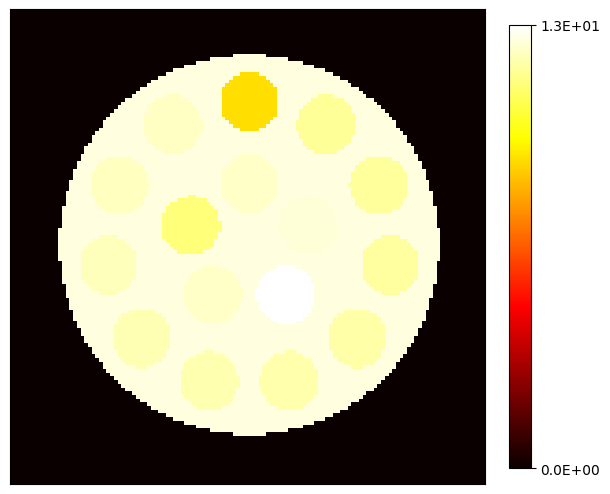

In [26]:
plt.figure(figsize=(6, 6), layout=PLT_LAYOUT)
plt.imshow(gamma_radius, origin='lower', vmin=0.0, vmax=gamma_radius.max(), cmap='hot', aspect='auto')
plt.xlim([ 0, imshape[0] - 1 ])
plt.ylim([ 0, imshape[1] - 1 ])
plt.xticks([])
plt.yticks([])
plt.axis('scaled')
plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1E}', ticks=[ 0.0, gamma_radius.max() ])

savefig('MNT_RADIUS_BND+')

plt.show()